In [1]:
# ==== Standard Libraries ====
import os
import numpy as np
import random
import time
import matplotlib.pyplot as plt

# ==== Medical Image IO ====
import nibabel 

# ==== Image Processing ====
from skimage.transform import resize
from skimage.io import imsave
from skimage.segmentation import mark_boundaries
from skimage.exposure import rescale_intensity

# ==== Keras & Deep Learning ====
from keras.models import Model, Sequential
from keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D,
    concatenate, add, Reshape, BatchNormalization, ReLU,
    DepthwiseConv2D, ZeroPadding2D, Lambda, Activation, Concatenate, Add
)
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras.losses import binary_crossentropy, categorical_crossentropy
from keras import backend as K
from keras.regularizers import l2

# ==== Scikit-learn ====
from sklearn.model_selection import train_test_split

In [2]:

from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:

img_rows, img_cols = 192 , 224
batch_size=32
epoch_size=100


In [4]:
def dice_loss(y_true, y_pred, smooth=1e-6):
   
    intersection = K.sum(y_true * y_pred, axis=[0,1,2])
    sums = K.sum(y_true, axis=[0,1,2]) + K.sum(y_pred, axis=[0,1,2])
    dice_per_class = (2. * intersection + smooth) / (sums + smooth)
    dice_loss_per_class = 1 - dice_per_class
    return K.mean(dice_loss_per_class)


def dice_coef(y_true, y_pred, smooth=1e-6):
    # Sum over spatial dimensions (height, width)
    intersection = K.sum(y_true * y_pred, axis=[0,1,2])
    sums = K.sum(y_true, axis=[0,1,2]) + K.sum(y_pred, axis=[0,1,2])
    dice_per_class = (2. * intersection + smooth) / (sums + smooth)
    return K.mean(dice_per_class)

In [5]:

def conv_bn_relu(x, filters, kernel_size=(3,3), strides=1, padding='same'):
    x = Conv2D(filters, kernel_size, strides=strides, padding=padding,
               kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


def residual_block(x, filters, strides=1):
    shortcut = Conv2D(filters, (1,1), strides=strides, padding='same',
                      kernel_initializer='he_normal')(x)
    shortcut = BatchNormalization()(shortcut)

    conv = conv_bn_relu(x, filters, strides=strides)
    conv = conv_bn_relu(conv, filters, strides=1)

    out = Add()([shortcut, conv])
    out = Activation('relu')(out)
    return out


def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    x = concatenate([x, skip])
    return x


def ResUNet(input_height=192, input_width=224, nClasses=3):

    inputs = Input(shape=(input_height, input_width, 1))

    # Encoder
    e1 = conv_bn_relu(inputs, 16)
    e2 = residual_block(e1, 32, strides=2)
    e3 = residual_block(e2, 64, strides=2)
    e4 = residual_block(e3, 128, strides=2)
    e5 = residual_block(e4, 256, strides=2)

    # Bridge
    b1 = conv_bn_relu(e5, 256)
    b2 = conv_bn_relu(b1, 256)

    # Decoder
    u1 = upsample_concat(b2, e4)
    d1 = residual_block(u1, 128)

    u2 = upsample_concat(d1, e3)
    d2 = residual_block(u2, 64)

    u3 = upsample_concat(d2, e2)
    d3 = residual_block(u3, 32)

    u4 = upsample_concat(d3, e1)
    d4 = residual_block(u4, 16)

    outputs = Conv2D(nClasses, (1,1), activation='softmax')(d4)

    model = Model(inputs=[inputs], outputs=[outputs], name='ResUNet')

    return model


In [ ]:
#batch generator
def generate_image_mask_from_data(batchsize):
  X_train=[]
  Y_train=[]
  batchcount = 0
  slide_index=np.arange(0,7917)
  random.shuffle(slide_index)


  for i in slide_index:
    image_2D=nibabel.load("/content/drive/MyDrive/classifir_mask_data/images_slides_train/image"+str(i)+".nii.gz").get_data()
    mask_2D=nibabel.load("/content/drive/MyDrive/classifir_mask_data/masks_slides_train/mask"+str(i)+".nii.gz").get_data()
    X_train.append(image_2D)
    Y_train.append(mask_2D)
    batchcount+=1
    if batchcount > batchsize:
      X_train = np.expand_dims(np.array(X_train,dtype=np.float32),axis=-1)
      Y_train = np.array(Y_train,dtype=np.float32)
      yield(X_train,Y_train)
      X_train=[]
      Y_train=[]
      batchcount = 0

train model with categorical_crossentropy loss

In [7]:
model = ResUNet()
opt = Adam(learning_rate=1e-3)

model.compile(
    optimizer=opt,
    loss=categorical_crossentropy,
    metrics=[dice_coef]
)

model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 224, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 224, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 224, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 96, 112, 32)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [8]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

In [ ]:

loss=[]
dice=[]
loss_val=[]
dice_val=[]
c=0



for epoch  in range(epoch_size):
  c=0
  print("start of epoch"+str(epoch+1)+"..........................................")
  for x,y in generate_image_mask_from_data(batch_size):
    
    
    
    X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.25,random_state=0)
    
    start_time = time.time()
    history=model.train_on_batch(X_train,Y_train,reset_metrics=True, return_dict=True)
    history_test=model.test_on_batch(X_test, Y_test, reset_metrics=True, return_dict=True)
    print(c+1)
    c+=1
  
  dice.append(history['dice_coef'])
  loss.append(history["loss"])
  loss_val.append(history_test["loss"])
  dice_val.append(history_test['dice_coef'])
  print('dice: ',history['dice_coef'])
  print('loss: ',history['loss'])
  print('dice_vall: ',history_test['dice_coef'])
  print('loss_vall: ',history_test['loss'])
  
  

print("finished")





start of epoch1..........................................


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  if sys.path[0] == '':


Streaming output truncated to the last 5000 lines.
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
dice:  0.9959410429000854
loss:  0.0015235444298014045
dice_vall:  0.993947446346283
loss_vall:  0.002267401898279786
start of epoch81..........................................
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105


In [ ]:
model.save_weights('/content/drive/MyDrive/mode_classify/unet/model/unet2_12jun2020_3ch_categorical_nodark_10085.h5')
np.save('/content/drive/MyDrive/mode_classify/unet/np/unet2_12jun2020_3ch_categorical_nodark_10085-Dice-list',dice)
np.save('/content/drive/MyDrive/mode_classify/unet/np/unet2_12jun2020_3ch_categorical_nodark_10085-Dice_val-list',dice_val)
np.save('/content/drive/MyDrive/mode_classify/unet/np/unet2_12jun2020_3ch_categorical_nodark_10085-loss-list',loss)
np.save('/content/drive/MyDrive/mode_classify/unet/np/unet2_12jun2020_3ch_categorical_nodark_10085-loss-val-list',loss_val) 

In [ ]:
loss=(np.load('/content/drive/MyDrive/mode_classify/unet/np/unet2_24dec2020_3ch_categorical_nodark_10085-loss-list.npy')).tolist()
dice=(np.load('/content/drive/MyDrive/mode_classify/unet/np/unet2_24dec2020_3ch_categorical_nodark_10085-Dice-list.npy')).tolist()
loss_val=(np.load('/content/drive/MyDrive/mode_classify/unet/np/unet2_24dec2020_3ch_categorical_nodark_10085-loss-val-list.npy')).tolist()
dice_val=(np.load('/content/drive/MyDrive/mode_classify/unet/np/unet2_24dec2020_3ch_categorical_nodark_10085-Dice_val-list.npy')).tolist()



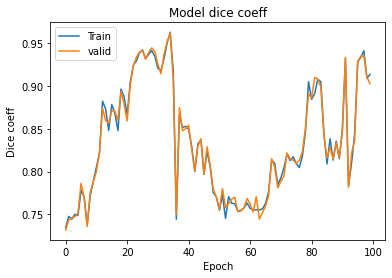

In [ ]:
plt.plot(dice)
plt.plot(dice_val)
plt.title('Model dice coeff')
plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'valid'], loc='upper left')
plt.savefig("dice_train_on _batch_epoch70_ln_constant_ln.png")




In [ ]:
np.mean(dice),np.mean(dice_val)

(0.8342168712615967, 0.8342449140548706)

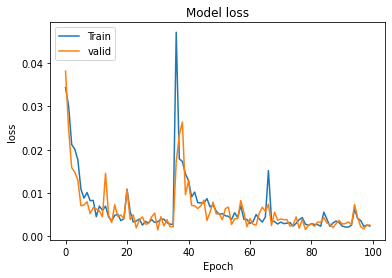

In [ ]:
plt.plot(loss)
plt.plot(loss_val)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'valid'], loc='upper left')
plt.savefig("loss_train_on _batch_epoch70_ln_constant_ln.png")



test model 

In [ ]:
model.load_weights("/content/drive/MyDrive/mode_classify/unet/model/unet2_24dec2020_3ch_categorical_nodark_10085.h5")

In [9]:
model.load_weights('/content/drive/MyDrive/mode_classify/unet/model/unet2_12jun2020_3ch_categorical_nodark_10085.h5')

In [11]:
dice1 = np.zeros((3,2164))
q=0
for i in range(2164):
  img=nibabel.load("/content/drive/MyDrive/classifir_mask_data/images_slides_test/image"+str(i)+".nii.gz").get_data()
  mask=nibabel.load("/content/drive/MyDrive/classifir_mask_data/masks_slides_test/mask"+str(i)+".nii.gz").get_data()
  img = np.array(img,dtype=np.float32)
  mask = np.array(mask,dtype=np.float32)
  pred = model.predict(img.reshape(-1,192,224,1))
  thereshod=0.5
  pred=(pred>thereshod).astype(int)
  
  
 
  for j in range(3):
    TP = np.sum(pred[0,:,:,j] * mask[:,:,j])
    union = np.sum(pred[0,:,:,j]) + np.sum(mask[:,:,j])
    dic_pred=2.0 * TP / (union+0.00001)
    dice1[j,q] = (dic_pred)

  q+=1


  print(i)
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [12]:
np.mean(dice1,axis=1)

array([0.99696989, 0.34972351, 0.00338458])

In [ ]:
np.mean(dic)


0.9323697211944425